In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os

from astropy import wcs
from astropy.io import fits

__Coadd WCS table__

In [2]:
t = Table.read('/Users/roz18/git/wise-mask-query/misc/astrom-atlas.fits')
print(len(t))

18240


In [3]:
t[:5]

COADD_ID,NAXIS [2],"CD [2,2]",CDELT [2],CRPIX [2],CRVAL [2],CTYPE [2],LONGPOLE,LATPOLE,PV2 [2]
str8,int32,float64,float64,float64,float64,str8,float64,float64,float64
0000m016,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -1.514444,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0
0000m031,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -3.028889,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0
0000m046,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -4.543333,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0
0000m061,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -6.057778,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0
0000m076,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -7.572222,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0


In [4]:
print(t['CD'][0], '\n')
print(t['CDELT'][0], '\n')
print(t['CRPIX'][0], '\n')
print(t['CRVAL'][0], '\n')
print(t['CTYPE'][0], '\n')

[[-0.00076389  0.        ]
 [ 0.          0.00076389]] 

[ 1.  1.] 

[ 1024.5  1024.5] 

[ 0.       -1.514444] 

['RA---TAN' 'DEC--TAN'] 



In [5]:
# coadd_index = 0
coadd_index = np.where(t['COADD_ID']=='2084p378')[0][0]

# Create a new WCS object. The number of axes must be set from the start
w = wcs.WCS(naxis=2)

# Set up gnomonic projection
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
# Vector properties may be set with Python lists, or Numpy arrays
w.wcs.cd = t['CD'][coadd_index]
w.wcs.crval = t['CRVAL'][coadd_index]
w.wcs.crpix = t['CRPIX'][coadd_index]
# CDELT is ignored since cd is present
# # w.wcs.cdelt = t['CDELT'][coadd_index]
w.wcs.lonpole = t['LONGPOLE'][coadd_index]
w.wcs.latpole = t['LATPOLE'][coadd_index]

# Epoch must be defined
w.wcs.equinox = 2000.

In [6]:
# # Some pixel coordinates of interest.
# pixcrd = np.array([[0, 0], [24, 38], [45, 98]], np.float_)

# # Convert pixel coordinates to world coordinates
# world = w.wcs_pix2world(pixcrd, True)
# print(world)

# # Convert the same coordinates back to pixel coordinates.
# pixcrd2 = w.wcs_world2pix(world, True)
# print(pixcrd2)

# # These should be the same as the original pixel coordinates, modulo
# # some floating-point error.
# assert np.max(np.abs(pixcrd - pixcrd2)) < 1e-6

# # Now, write out the WCS object as a FITS header
# header = w.to_header()

# # header is an astropy.io.fits.Header object.  We can use it to create a new
# # PrimaryHDU and write it to a file.
# hdu = fits.PrimaryHDU(header=header)
# # Save to FITS file
# # hdu.writeto('test.fits')

In [7]:
# Some pixel coordinates of interest.
# [0.5, 0.5] and [2048.5, 2048.5] are the corners of the image
pixcrd = np.array([[0.5, 0.5], [1024.5, 1024.5], [2048.5, 2048.5]], dtype=float)
# Convert pixel coordinates to world coordinates
world = w.wcs_pix2world(pixcrd, True)
print(world)

[[ 209.40264915   37.07490358]
 [ 208.422369     37.861111  ]
 [ 207.42106207   38.639017  ]]


In [8]:
# Some world coordinates of interest.
world = np.array([[208.422369, 37.861111], [300., 38.639017]], dtype=float)
# Convert pixel coordinates to world coordinates
pixcrd = w.wcs_world2pix(world, True)
print(pixcrd)

[[   1024.5           1024.5       ]
 [-158875.71361155  104683.66209511]]


__Verify with FITS image__

In [9]:
filename = '/Users/roz18/git/wise-mask-query/misc/unwise-2084p378-msk.fits'
hdulist = fits.open(filename)
w1 = wcs.WCS(hdulist[0].header)

img = fits.getdata(filename)
print(img.shape)

(2048, 2048)


In [10]:
# Some pixel coordinates of interest.
# [0.5, 0.5] and [2048.5, 2048.5] are the corners of the image
pixcrd = np.array([[0.5, 0.5], [1024.5, 1024.5], [2048.5, 2048.5]], dtype=float)
# Convert pixel coordinates to world coordinates
world = w1.wcs_pix2world(pixcrd, True)
print(world)

[[ 209.40264915   37.07490358]
 [ 208.422369     37.861111  ]
 [ 207.42106207   38.639017  ]]


__Add RA/Dec values to coadd table__

In [17]:
ra_center, dec_center = np.zeros([2, len(t)])
ra_corners = np.zeros([len(t), 4])
dec_corners = np.zeros([len(t), 4])

for coadd_index in range(len(t)):
# for coadd_index in range(10):

    w = wcs.WCS(naxis=2)
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    w.wcs.cd = t['CD'][coadd_index]
    w.wcs.crval = t['CRVAL'][coadd_index]
    w.wcs.crpix = t['CRPIX'][coadd_index]
    w.wcs.lonpole = t['LONGPOLE'][coadd_index]
    w.wcs.latpole = t['LATPOLE'][coadd_index]
    w.wcs.equinox = 2000.
    
    pixcrd = np.array([[1024.5, 1024.5]], dtype=float)
    # Convert pixel coordinates to world coordinates
    world = w.wcs_pix2world(pixcrd, True)

    # print(t['COADD_ID'][coadd_index])
    # print('{:7.3f}   {:7.3f}'.format(*world[0]))
    
    ra_center[coadd_index], dec_center[coadd_index] = world[0]
    
    # RA/Dec of four corners
    pixcrd = np.array([[0.5, 0.5], [2048.5, 0.5], [2048.5, 2048.5], [0.5, 2048.5]], dtype=float)
    world = w.wcs_pix2world(pixcrd, True)
    ra_corners[coadd_index], dec_corners[coadd_index] = world.transpose()

t['ra_center'] = ra_center
t['dec_center'] = dec_center
t['ra_corners'] = ra_corners
t['dec_corners'] = dec_corners

In [22]:
t.write('/Users/roz18/git/wise-mask-query/misc/astrom-atlas_radec_added.fits')

In [119]:
t[55:60]

COADD_ID,NAXIS [2],"CD [2,2]",CDELT [2],CRPIX [2],CRVAL [2],CTYPE [2],LONGPOLE,LATPOLE,PV2 [2],ra_center,dec_center
str8,int32,float64,float64,float64,float64,str8,float64,float64,float64,float64,float64
0000m849,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -84.808889,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0,4.74865902874e-30,-84.808889
0000m864,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -86.323333,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0,6.70009208182e-30,-86.323333
0000m879,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -87.837778,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0,1.13877986304e-29,-87.837778
0000m894,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -89.352222,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0,3.80031880279e-29,-89.352222
0000p000,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. 0.0,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0,4.2964952915e-31,0.0


In [76]:
t[:5]

COADD_ID,NAXIS [2],"CD [2,2]",CDELT [2],CRPIX [2],CRVAL [2],CTYPE [2],LONGPOLE,LATPOLE,PV2 [2],ra_center,dec_center
str8,int32,float64,float64,float64,float64,str8,float64,float64,float64,float64,float64
0000m016,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -1.514444,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0,4.29799660697e-31,-1.514444
0000m031,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -3.028889,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0,4.30250580778e-31,-3.028889
0000m046,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -4.543333,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0,4.31003868411e-31,-4.543333
0000m061,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -6.057778,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0,4.32062172309e-31,-6.057778
0000m076,2048 .. 2048,-0.000763888888889 .. 0.000763888888889,1.0 .. 1.0,1024.5 .. 1024.5,0.0 .. -7.572222,RA---TAN .. DEC--TAN,180.0,0.0,0.0 .. 0.0,4.33429229686e-31,-7.572222


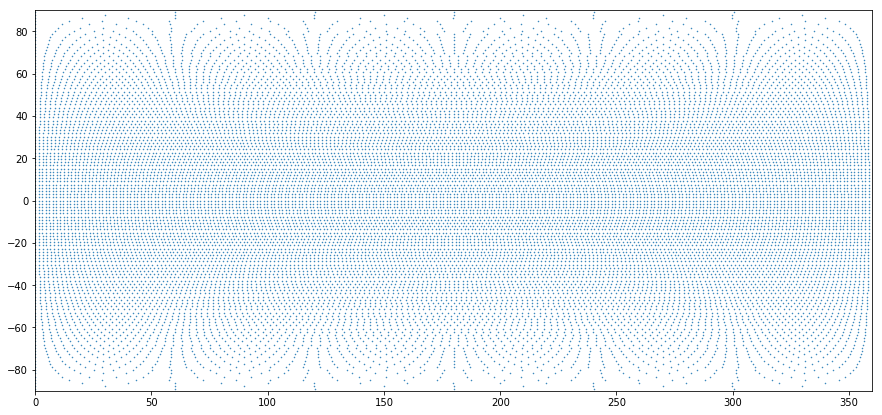

In [69]:
plt.figure(figsize=(15, 7))
plt.plot(ra_center, dec_center, '.', markersize=1)
plt.axis([0, 360, -90, 90])
plt.show()

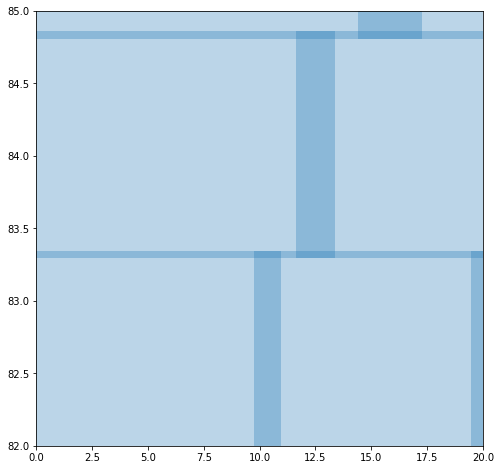

In [124]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 8))
for index in range(len(t)):
    if (80<dec_center[index]<89):
        ax.add_patch(
            patches.Rectangle(
                (ra_center[index], dec_center[index]),  # (x,y)
                1.5644/np.cos(dec_center[index]/180*np.pi),  # width
                1.5644,  # height
                alpha=0.3,
            )
        )
plt.axis([0, 20, 82, 85])
plt.show()

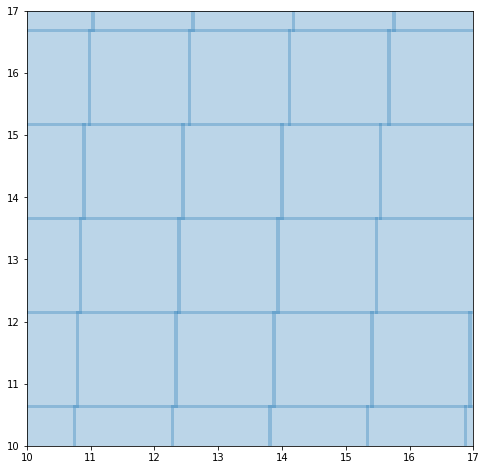

In [115]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 8))
for index in range(len(t)):
    if (7<ra_center[index]<20) and (7<dec_center[index]<20):
        ax.add_patch(
            patches.Rectangle(
                (ra_center[index], dec_center[index]),  # (x,y)
                1.5644/np.cos(dec_center[index]/180*np.pi),  # width
                1.5644,  # height
                alpha=0.3,
            )
        )
# plt.axis([0, 360, -90, 90])
plt.axis([10, 17, 10, 17])
plt.show()